In [33]:
import sys
sys.path.append('../')
sys.path.insert(0, '../terrace')

%load_ext autoreload
%autoreload 2

In [34]:
from tqdm import tqdm
from copy import deepcopy
import torch
import torch.nn as nn
import torch.nn.functional as F
import rdkit
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from common.cfg_utils import get_config
from common.metrics import *
from common.losses import *
from common.cfg_utils import *
from common.old_routine import *
from datasets.make_dataset import *
from models.gnn_bind import *
from models.learnable_ff import LearnableFF
from routines.ai_routine import *
from terrace.batch import *
from terrace.type_data import *
from terrace.comp_node import *
from torchmetrics import *
from datasets.data_types import *
from models.val_model import *
from datasets.bigbind_screen import *
from datasets.lit_pcba import *
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from common.cache import *
from glob import glob
import wandb
from git_timewarp import GitTimeWarp

In [3]:
cfg = get_config("../configs", "short_thicc_op_gnn")
cfg.data.sna_frac = 1
cfg.data.cache = False
cfg.data.use_rec = True
cfg.data.use_lig = False
loader = make_dataloader(cfg, "val")
in_node = Input(loader.get_type_data())
len(loader.dataset[1000].lig.ndata)

28

In [138]:
csv_dict = {
    ("LIT-PCBA", "gnina"): "screen_lit_pcba_test_gnina.csv",
    ("LIT-PCBA", "e2ebind"): "screen_lit_pcba_test_37jstv82_v4.csv",
    ("LIT-PCBA", "e2ebind+gnina"): "screen_lit_pcba_test_combo_37jstv82_v4_gnina_0.1.csv",
    ("BigBind", "e2ebind"): "screen_bigbind_test_37jstv82_v4.csv"
}
def create_combined_df(csv_dict):
    dfs = []
    for (dataset, model), csv in csv_dict.items():
        df = pd.read_csv("../outputs/" + csv)
        df["model"] = model
        df["dataset"] = dataset
        if dataset == "BigBind":
            df = df[np.logical_and(df["total actives in set"] == 10, df["EF1%"] != 0)].reset_index(drop=True)
        dfs.append(df)
    return pd.concat(dfs)
comb_df = create_combined_df(csv_dict)

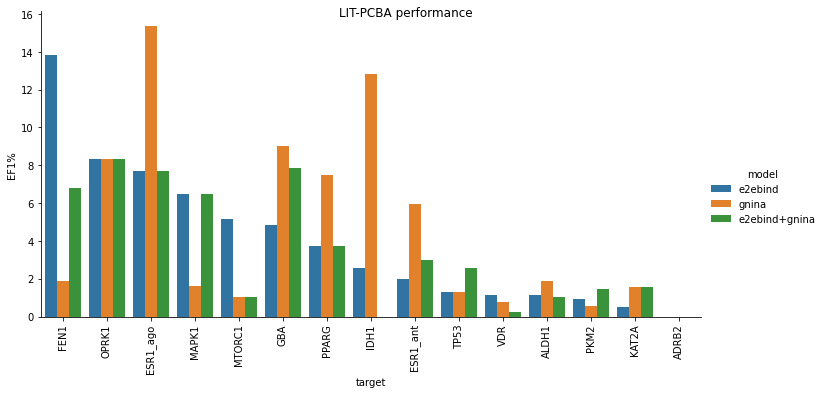

In [135]:
pcba_order = list(comb_df.query("dataset == 'LIT-PCBA' and model == 'e2ebind'").sort_values(by="EF1%", ascending=False).target)
bb_order = list(comb_df.query("dataset == 'BigBind' and model == 'e2ebind'").sort_values(by="EF1%", ascending=False).target)
g = sns.catplot(x="target", y="EF1%", hue="model",# col="dataset",
                data=comb_df,
                order=pcba_order,# + bb_order,
                hue_order = [ 'e2ebind', 'gnina', 'e2ebind+gnina' ],
                sharex = False,
                aspect=2,
                kind='bar')

g.set_xticklabels(rotation=90)
g.fig.suptitle("LIT-PCBA performance")
g.savefig("../outputs/lit_pcba.png")

In [137]:
comb_df.query("dataset == 'LIT-PCBA' and model == 'e2ebind'")["EF1%"].median()

2.5640175

In [ ]:
g = sns.barplot(data=df, x="target", y="EF1%")
g.set_xticklabels(g.get_xticklabels(), rotation=-80)

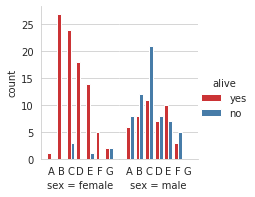

In [20]:
titanic = sns.load_dataset("titanic")
sns.set_style('whitegrid')
g = sns.catplot(x="deck", hue="alive", col="sex",
                data=titanic[titanic.deck.notnull()],
                height=3, kind='count', aspect=.4, palette='Set1')
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title())
    ax.set_title('')
    ax.margins(x=0.1) # slightly more margin as a separation
plt.subplots_adjust(wspace=0, bottom=0.18, left=0.06)
plt.show()

In [ ]:
y1 = np.random.randn(5)
y2 = np.random.randn(15)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
for y, ax in ((y1, ax1), (y2, ax2)):
    x = np.arange(len(y))
    rects = ax.bar(x, y, width=2)

In [ ]:
mol = Chem.MolFromSmiles(loader.dataset.activities.lig_smiles[0])
Chem.Draw.MolToFile(mol, "../outputs/ex_mol.png")

In [ ]:
targ = BigBindScreenDataset.get_all_targets(cfg, "val")[0]
dataset = BigBindScreenDataset(cfg, targ, "val")

In [ ]:
sorted(vals, key=lambda x: -x)

In [ ]:
api = wandb.Api()
run_id = "1nhqz8vw"
run = api.run(f"{cfg.project}/{run_id}")

In [ ]:
artifact = get_weight_artifact(run)
out_filename = f"../outputs/lit_pca_results_{run_id}_{artifact.version}.csv"

In [ ]:
df = pd.read_csv(out_filename)

In [ ]:
df = df.sort_values(by="EF1%", ascending=False)

In [ ]:
prior_lit_pcba = pd.read_csv("../prior_work/lit_pcba.csv")
prior_lit_pcba = prior_lit_pcba.set_index("target")

In [ ]:
name2csv = {
    "e2ebind": "../outputs/val_screen_1nhqz8vw_v0.csv",
    "vina": "../outputs/val_screen_vina.csv",
}

In [ ]:
sorted_df.query("`total actives in set` > 1")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def make_screen_fig(cfg, name2csv, sort_key="e2ebind", min_actives=10):

    name2df = {}
    for name, csv in name2csv.items():
        df = pd.read_csv(csv).set_index("target")
        df = df.query("`total actives in set` >= @min_actives")
        name2df[name] = df
    sorted_df = name2df[sort_key]
    sorted_df = sorted_df.sort_values(by="EF1%", ascending=False)

    fig, ax = plt.subplots()
    x = np.arange(len(sorted_df))
    width = 0.25

    name2ef1 = {}
    for i, (name, df) in enumerate(name2df.items()):
        ef1_scores = df["EF1%"][sorted_df.index]
        name2ef1[name] = ef1_scores
        rects = ax.bar(x + width*(i-1)/2, ef1_scores, width, label=name)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('EF1%')
    ax.set_title("Performance on BigBind Screen")
    ax.set_xticks(x)
    targets = [ t.split("_")[0] for t in sorted_df.index ]
    ax.set_xticklabels(targets, rotation='vertical')
    ax.set_xlabel("Target")
    ax.legend()

    fig.set_size_inches(15, 5)
    fig.tight_layout()
    out_filename = "../outputs/val_screen_results.png"
    fig.savefig(out_filename, transparent=False)

make_screen_fig(cfg, name2csv)

In [ ]:
run_ids = ["1nhqz8vw", "1socj7qg" ]
name2model = {}
api = wandb.Api()
for run_id in run_ids:
    run = api.run(f"{cfg.project}/{run_id}") # wandb.init(project=cfg.project, id=run_id, resume=True)
    cfg = get_run_config(run, cfg)
    artifact = api.artifact(f"{cfg.project}/model-{run.id}:latest", type='model')
    artifact_dir = artifact.download()
    checkpoint_file = artifact_dir + "/model.ckpt"
    routine = AIRoutine.from_checkpoint(cfg, checkpoint_file)
    name2model[run.name] = routine.model

In [ ]:
import pandas as pd
from glob import glob
from datasets.graphs.mol_graph import MolGraph, mol_graph_from_sdf
from datasets.graphs.prot_graph import ProtGraph, prot_graph_from_pdb
from datasets.data_types import ActivityData, IsActiveData
from terrace.batch import make_batch

for screen_csv in glob(cfg.platform.bigbind_dir + "/val_screens/*.csv"):
    screen_df = pd.read_csv(screen_csv)
    break

In [ ]:
batch_size = 16
batch_arr = []
for i, row in tqdm(screen_df.iterrows()):
    lig_file = cfg.platform.bigbind_dir + "/" + row.lig_file
    rec_file = cfg.platform.bigbind_dir + "/" + row.ex_rec_file
    lig_graph = mol_graph_from_sdf(cfg, lig_file)
    rec_graph = prot_graph_from_pdb(cfg, rec_file)
    is_active = torch.tensor(row.active, dtype=bool)
    data = IsActiveData(lig_graph, rec_graph, is_active)
    batch_arr.append(data)
    if i == batch_size:
        break

In [ ]:
batch = make_batch(batch_arr)

In [ ]:
for name, model in name2model.items():
    print(name, model(batch))

In [ ]:
batch = next(iter(loader))

In [ ]:
model = make_model(cfg, in_node)

In [ ]:
outputs = model(batch)
norm_outs = torch.sigmoid(outputs)
print(outputs)
print(norm_outs)
print(batch.is_active)

In [ ]:
preds = (norm_outs > 0.5)
tpr = sum((preds == batch.is_active) & batch.is_active) / sum(batch.is_active)
tnr = sum((preds == batch.is_active) & ~batch.is_active) / sum(~batch.is_active)
0.5*(tpr + tnr)

In [ ]:
for key, met in get_metrics(cfg).items():
    print(key, met(outputs, batch))

In [ ]:
activities = loader.dataset.activities

In [ ]:
from datasets.graphs.mol_graph import *
sdf_file = cfg.platform.bigbind_dir + "/" + activities.lig_file[0]
get_node_and_edge_nums_from_sdf(cfg, sdf_file)

In [ ]:
from datasets.graphs.prot_graph import *
pdb_file = cfg.platform.bigbind_dir + "/" + activities.ex_rec_file[0]
get_node_and_edge_nums_from_pdb(cfg, pdb_file)

In [ ]:
from datasets.cacheable_dataset import *
cfg.platform.cache_dir + "/" + cfg.dataset + "/" + get_dataset_hash(cfg) + "/graph_sizes.csv"

In [ ]:
from datasets.edge_num_sampler import *
cfg = get_config("../configs", "short_thicc_op_gnn")
sampler = EdgeNumSampler(cfg, loader.dataset)
for sample in sampler:
    print(sample)
    break

In [ ]:
activities.lig_smiles.str.len().argmax()

In [ ]:
activities.lig_file[42638]

In [ ]:
for b in loader.dataset:
    print(len(b.lig.edata))

In [ ]:
b = loader.dataset[42638]
len(b.rec.edata), len(b.rec.ndata)

In [ ]:
b.lig.edata.batch_size

In [ ]:
b.lig.ndata.cat_feat

In [ ]:
for batch in loader:
    print(len(batch.lig.edata), len(batch.lig.ndata))

In [ ]:
bal_acc = Accuracy(average="macro", num_classes=2, multiclass=True)
bal_acc(norm_outs, batch.is_active)

In [ ]:
activities = loader.dataset.activities
activities

In [ ]:
nn.ModuleDict({"train_metric": nn.Linear(10, 10)})

In [ ]:
dataset = make_dataset(cfg, "val")

In [ ]:
sum(dataset.activities.active)/len(dataset.activities)

In [ ]:
torch.tensor(energies).var()

In [ ]:
from datasets.vina_score import VinaScoreDataset
dataset = VinaScoreDataset(cfg, "train")

In [ ]:
(torch.randn((3,))*2).tolist()

In [ ]:
lig_file = dataset.lig_files[0]
lig = next(Chem.SDMolSupplier(lig_file, sanitize=True))
conf = lig.GetConformer()
lig_center = Chem.rdMolTransforms.ComputeCentroid(conf)
new_pos = lig_center + conf.GetAtomPosition(0)
print(conf.GetAtomPosition(0).x)
conf.SetAtomPosition(0, new_pos)
print(conf.GetAtomPosition(0).x)

In [ ]:
lig = Chem.MolFromSmiles(smiles)

In [ ]:
batch = next(iter(loader))

In [ ]:
cfg = get_config("../configs", "outer_prod_gnn")
# cfg.model.type
model = make_model(cfg, in_node)
y_pred = model(batch)
y_pred

In [ ]:
cfg = get_config("../configs", "learnable_ff")
model = LearnableFF(cfg, in_node)
y_pred = model(batch)

In [ ]:
get_losses(cfg, batch, y_pred)

In [ ]:
torch.einsum('lf,rf->lr', lig_feat, rec_feat).shape

In [ ]:
lig_feat.device

In [ ]:
rot, _ = torch.linalg.qr(torch.randn((3,3)))
trans = torch.randn(3,)
# torch.linalg.det(rand_rot)
# torch.einsum("ij,jk->ik")
coord = batch.lig.ndata.coord
trans_coord = torch.einsum('ij,bj->bi',rot,coord) + trans

In [ ]:
batch_t = deepcopy(batch)
batch_t.lig.ndata.coord = trans_coord

In [ ]:
(lig_coord - lig_coord.mean(0)).mean(0)

In [ ]:
lig_coord = batch.lig.ndata.coord
rec_coord = batch.rec.ndata.coord
dists = torch.zeros((lig_coord.shape[0], rec_coord.shape[0]))
for i, lc in enumerate(lig_coord):
    for j, rc in enumerate(rec_coord):
        dists[i,j] = torch.linalg.norm(lc - rc)
dists

In [ ]:
mask = torch.zeros((lig_coord.shape[0], rec_coord.shape[0]))
tot_rec = 0
tot_lig = 0
rec_graph = batch.rec.dgl_batch
lig_graph = batch.lig.dgl_batch
for r, l in zip(rec_graph.batch_num_nodes(), lig_graph.batch_num_nodes()):
    mask[tot_lig:tot_lig+l,tot_rec:tot_rec+r] = 1.0
    tot_rec += r
    tot_lig += l
mask

In [ ]:
(1/(torch.cdist(lig_coord, rec_coord))**2)*mask

In [ ]:
# from datasets.graphs.plot_graph import *
# plot_graph(batch_t.lig[0])

In [ ]:
t1 = torch.randn((10, 100))
t2 = torch.randn((10, 50))
torch.einsum('bi,bj->bij', t1, t2).reshape((t1.size(0), -1)).shape